# Quadratic Unconstrained Binary Optimization Problems

## Contents

1. **Quadratic Unconstrained Binary Optimization (QUBO) formulation**
2. **Quantum Approximate Optimization Algorithm (QAOA)**
3. **A quadratic optimization example**
4. **A linear optimization example**
5. **A Max Cut example**
6. **A Travelling Salesman Problem (TSP) example**


## Quadratic Unconstrained Binary Optimization (QUBO)

## Quadratic Problem example

In this example, we will solve an instance of a Quadratic Assignment Problem (QAP).
In this problem, there is $n$ facilities and $n$ locations. 
Locations are distant to one another, specified as a matrix $(D_{ij})$.
Also, facilities are connected via a flow matrix $(F_{ij})$.

Decision variable $x_{ij} = 1$ if facility $i$ is assigned to location $j$. 

The objective is to find an assignment of facilities to locations, in order to minimize the weighted flow.

$\sum_{i=1}^{n}\sum_{j=1}^{n}\sum_{k=1}^{n}\sum_{l=1}^{n} F_{ij} D_{kl} x_{ik} x_{jl}$ 

with: 

$\sum_{i=1}^{n} x_{ij} = 1$ and $j=1,n$, to express that a location hosts one facility

$\sum_{j=1}^{n} x_{ij} = 1$ and $i=1,n$, to express that a facility sits a one location

$x_{ij} \in {0,1}$ 



For example, let's consider a Flow matrix: 
$\begin{pmatrix}
0 & 5 & 2\\
5 & 0 & 3\\
2 & 3 & 0
\end{pmatrix}$ 
and a Distance matrix: 
$\begin{pmatrix}
0 & 8 & 15\\
8 & 0 & 13\\
15 & 13 & 0
\end{pmatrix}$ 

Rewriting the assignment variables to use a single digit subscript:

$(x_{11}, x_{12}, x_{13}, x_{21}, x_{22}, x_{23}, x_{31}, x_{32}, x_{33}) = (x_1, x_2, x_3, x_4, x_5, x_6, x_7,x_8, x_9)$

The QAP becomes:

$min x_0 = 80 x_1 x_5 + 150 x_1 x_6 + 32 x_1 x_8 + 60 x_1 x_9 + 80 x_2 x_4 + 130 x_2 x_6 + 60 x_2 x_7 + 52 x_2 x_9 +
150 x_3 x_4 + 130 x_3 x_5 + 60 x_3 x_7 + 52 x_3 x_8 + 48 x_4 x_8 + 90 x_4 x_9 + 78 x_5 x_9 + 78 x_6 x_8$

subject to the assignment constraints:

$x_1 + x_2 + x_3 = 1$, $x_4 + x_5 + x_6 = 1$, $x_7 + x_8 + x_9 = 1$ 

$x_1 + x_4 + x_7 = 1$, $x_2 + x_5 + x_8 = 1$, $x_3 + x_6 + x_9 = 1$ 


Because QUBO stands for unconstrained, we should remove the assignment constraints. 

We can do so by converting the constraints into penalty terms, added to the objective function.

The penalty terms are the constraint equations, squared with a penalty factor $P$, sufficiently high to prevent constraints from being violated:

$min x_0 = 80 x_1 x_5 + 150 x_1 x_6 + 32 x_1 x_8 + 60 x_1 x_9 + 80 x_2 x_4 + 130 x_2 x_6 + 60 x_2 x_7 + 52 x_2 x_9 
+ 150 x_3 x_4 + 130 x_3 x_5 + 60 x_3 x_7 + 52 x_3 x_8 + 48 x_4 x_8 + 90 x_4 x_9 + 78 x_5 x_9 + 78 x_6 x_8 $ \
$+ P (x_1 + x_2 + x_3 -1)^2 + P (x_4 + x_5 + x_6 -1)^2 + P (x_7 + x_8 + x_9 -1)^2 $ \
$+ P (x_1 + x_4 + x_7 -1)^2 + P (x_2 + x_5 + x_8 -1)^2 + P (x_3 + x_6 + x_9 -1)^2 $

But, Qiskit Algorithms library allows us to define the QUBO directly with the constraints.


In [8]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendSampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    OptimizationResultStatus,
)
from qiskit_aer import Aer
from qiskit_optimization import QuadraticProgram

# create our QUBO for QAP
qubo = QuadraticProgram()
for i in range(1,10):
    qubo.binary_var(f"x{i}")
qubo.minimize(quadratic={("x1", "x5"): 80, ("x1", "x6"): 150, ("x1", "x8"): 32, ("x1","x9"): 60, ("x2","x4"): 80, ("x2", "x6"): 130, ("x2","x7"): 60, ("x2","x9"): 52, ("x3","x4"): 150, ("x3","x5"): 130, ("x3","x7"): 60, ("x3","x8"): 52, ("x4","x8"): 48, ("x4","x9"): 90, ("x5","x9"): 78, ("x6","x8"): 78})
qubo.linear_constraint(linear={"x1": 1, "x2": 1, "x3": 1}, sense="==", rhs=1)
qubo.linear_constraint(linear={"x4": 1, "x5": 1, "x6": 1}, sense="==", rhs=1)
qubo.linear_constraint(linear={"x7": 1, "x8": 1, "x9": 1}, sense="==", rhs=1)
qubo.linear_constraint(linear={"x1": 1, "x4": 1, "x7": 1}, sense="==", rhs=1)
qubo.linear_constraint(linear={"x2": 1, "x5": 1, "x8": 1}, sense="==", rhs=1)
qubo.linear_constraint(linear={"x3": 1, "x6": 1, "x9": 1}, sense="==", rhs=1)
print(qubo.prettyprint())


Problem name: 

Minimize
  80*x1*x5 + 150*x1*x6 + 32*x1*x8 + 60*x1*x9 + 80*x2*x4 + 130*x2*x6 + 60*x2*x7
  + 52*x2*x9 + 150*x3*x4 + 130*x3*x5 + 60*x3*x7 + 52*x3*x8 + 48*x4*x8 + 90*x4*x9
  + 78*x5*x9 + 78*x6*x8

Subject to
  Linear constraints (6)
    x1 + x2 + x3 == 1  'c0'
    x4 + x5 + x6 == 1  'c1'
    x7 + x8 + x9 == 1  'c2'
    x1 + x4 + x7 == 1  'c3'
    x2 + x5 + x8 == 1  'c4'
    x3 + x6 + x9 == 1  'c5'

  Binary variables (9)
    x1 x2 x3 x4 x5 x6 x7 x8 x9



In [9]:
# Set up the quantum backend
algorithm_globals.random_seed = 142
simulator = Aer.get_backend("aer_simulator")
simulator.set_options(
    max_parallel_threads=128,  # Use multiple threads
)
# Define the QAOA solver
qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)
qaoa_solver = MinimumEigenOptimizer(qaoa)
qaoa_result = qaoa_solver.solve(qubo)
print(qaoa_result.prettyprint())


/tmp/ipykernel_2563/3069322072.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)


objective function value: 190.0
variable values: x1=0.0, x2=0.0, x3=1.0, x4=0.0, x5=1.0, x6=0.0, x7=1.0, x8=0.0, x9=0.0
status: SUCCESS


## Linear Binary Optimization Problem example

In this example, we will solve an instance of a Linear Binary Optimization problem: the **Knapsack** problem.

As a reminder, this problem deals with a list of objects $i = 1, ..., n$, each with a weight $W_i$ and a value $C_i$.

The objective is to select a subset of objects, such that the total weight is less or equal to a limit W, yet maximizing the total value.

Let the binary variables $x_i$ indicate if object $i$ is selected ($x_i = 1$).

We wish to minimize: 

$-\sum_{i=1}^{n} C_i x_i$ 

with the constraint: 

$\sum_{i=1}^{n} W_i x_i \leq W$ 

$x_i \in {0,1}$ 

For example, let's consider the following instance:

Minimize: $-5 x_1 - 3 x_2 - 4 x_3$

Under the constraint:

$3 x_0 + x_2 + x_3 \leq 3$

This problem does not fit the QUBO formulation.

To express it in a QUBO form, we: 
- rewrite the inequality constraint as an equality
- insert this equality constraint as a penalty term (as above)

To change the inequality, we add a slack binary variable(s). In this case, because we need to reach 3, we need to add 2 binary slack variables:

$3 x_1 + x_2 + x_3 \leq 3 \Leftrightarrow  3 x_1 + x_2 + x_3 + y_1 + 2 y_2 = 3$

To remove the constraint, we add the constraint expression to the objective function, with a penalty factor $P$ that avoids violating the constraint:

Minimize: $-5 x_1 - 3 x_2 - 4 x_3 + P (3 x_1 + x_2 + x_3 + y_1 + 2 y_2 - 3)^2$

The original objective function range is in $[-12, 0]$, so any violation of the constraint must result in a value greater than the maximum value, let's choose $P = 13$.


In [1]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendSampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    OptimizationResultStatus,
)
from qiskit_aer import Aer
from qiskit_optimization import QuadraticProgram

# create our QUBO for Knapsack
qubo = QuadraticProgram()
qubo.binary_var("x1")
qubo.binary_var("x2")
qubo.binary_var("x3")
qubo.binary_var("y1")
qubo.binary_var("y2")
qubo.minimize(linear={("x1"): -5, ("x2"): -3, ("x3"): -4})
qubo.linear_constraint(linear={"x1": 3, "x2": 1, "x3": 1}, sense="<=", rhs=3)
print(qubo.prettyprint())


Problem name: 

Minimize
  -5*x1 - 3*x2 - 4*x3

Subject to
  Linear constraints (1)
    3*x1 + x2 + x3 <= 3  'c0'

  Binary variables (5)
    x1 x2 x3 y1 y2



In [6]:
# Set up the quantum backend
algorithm_globals.random_seed = 142
simulator = Aer.get_backend("aer_simulator")
simulator.set_options(
    max_parallel_threads=128,  # Use multiple threads
)
# Define the QAOA solver
qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)
qaoa_solver = MinimumEigenOptimizer(qaoa)
qaoa_result = qaoa_solver.solve(qubo)
print(qaoa_result.prettyprint())


/tmp/ipykernel_7055/1819144987.py:10: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)


objective function value: -7.0
variable values: x1=0.0, x2=1.0, x3=1.0, y1=0.0, y2=0.0
status: SUCCESS


## **QUBO for Graph algorithms**

Now, we will explore the following topics:

- Understanding the Max-Cut problem and its relation to the Ising model
- Transitioning to quantum methods for optimization problem formulation
- Converting between QUBO and Ising representations
- Applying the QUBO model to tackle combinatorial optimization challenges


## **Graph Cut Definition**

A **graph cut** is a fundamental concept in graph theory that refers to a **partition of the vertices** of a graph into two disjoint subsets, separating the graph into two parts. The set of edges that have one endpoint in each subset is called the **cut set**, and the goal of different graph cut problems is often to minimize or maximize the number (or total weight) of these edges.

### **Formal Definition**
Given an **undirected graph** $ G = (V, E) $, where $ V $ is the set of vertices and $ E $ is the set of edges, a **cut** is defined by a partition of $ V $ into two disjoint subsets $ S $ and $ \bar{S} $ such that:
- $ S \cup \bar{S} = V $
- $ S \cap \bar{S} = \emptyset $

The **cut-set** consists of all edges that have **one endpoint in $ S $ and the other in $ \bar{S} $**:
$$
\text{Cut}(S, \bar{S}) = \{ (u, v) \in E \mid u \in S, v \in \bar{S} \}
$$

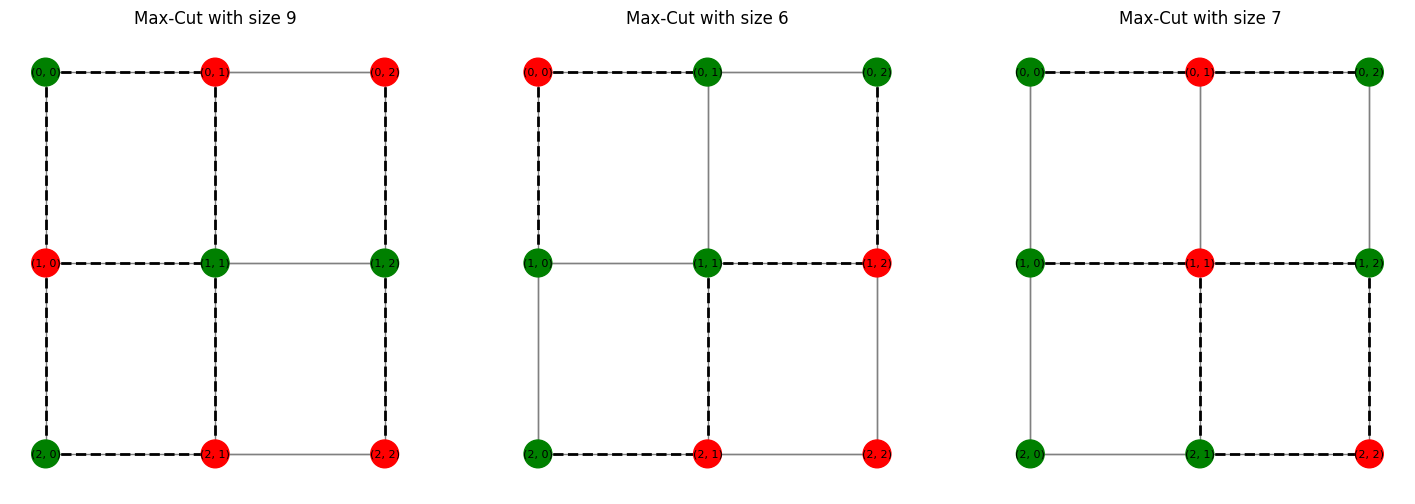

In [2]:
import matplotlib
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random


def random_cut_partition(graph):
    """Find a random partition for the Max-Cut problem."""
    partition = {}
    for node in graph.nodes():
        partition[node] = random.choice([0, 1])  # Randomly assign to one of two sets
    return partition

def plot_max_cut(graph, partition,ax):
    """Visualize the Max-Cut solution with colored nodes and dashed edges between cuts."""
    colors = ['red' if partition[node] == 0 else 'green' for node in graph.nodes()]
    pos = {(x,y):(y,-x) for x,y in graph.nodes()}
    
    # Identify edges that cross the cut
    cut_edges = [(u, v) for u, v in graph.edges() if partition[u] != partition[v]]
    same_set_edges = [(u, v) for u, v in graph.edges() if partition[u] == partition[v]]
    
  
    nx.draw(graph, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=400, font_size=8,ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=cut_edges, style='dashed', edge_color='black', width=2,ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=same_set_edges, edge_color='gray', width=1,ax=ax)
    
    ax.set_title(f"Max-Cut with size {len(cut_edges)}")


# Create a simple 5-node graph
G = nx.grid_2d_graph(3,3)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Plot the graph with Max-Cut coloring
for i in range(len(axes)):
    plot_max_cut(G, random_cut_partition(G),axes[i])
plt.show()

## **Max-Cut Problem Formulation**

The **Max-Cut problem** is a fundamental problem in graph theory and combinatorial optimization. Given an **undirected graph** $ G = (V, E) $, where $ V $ is the set of vertices and $ E $ is the set of edges, the goal is to find a partition of the vertex set into two subsets $ S $ and $ \bar{S} $ that **maximizes the number (or total weight) of edges** that cross between the two subsets.

### **Mathematical Formulation**
Let:
- $ x_i $ be a binary decision variable for each vertex $ i $, where:
  $$
  x_i =
  \begin{cases}
  1, & \text{if node } i \text{ is in subset } S \\
  0, & \text{if node } i \text{ is in subset } \bar{S}
  \end{cases}
  $$
- Each edge $ (i, j) \in E $ contributes to the cut **if and only if** its endpoints are in different subsets, meaning $ x_i \neq x_j $.

The **Max-Cut objective function** is given by:
$$
\max \sum_{(i, j) \in E} w_{ij} (x_i \oplus x_j)
$$
where:
- $ w_{ij} $ is the weight of edge $ (i, j) $ (assumed 1 in the unweighted case).
- $ \oplus $ represents the **XOR** operation, which equals 1 if $ x_i \neq x_j $ (i.e., the edge is cut).




### **Reformulation in Terms of the Ising Model**
To solve the Max-Cut problem using **quantum optimization**, we express it in terms of spin variables:
- Define $ s_i $ as a spin variable taking values in $ \{-1, +1\} $, where:
  $$
  s_i = 2x_i - 1
  $$
- The Max-Cut objective function can then be rewritten as:
  $$
  \max \frac{1}{2} \sum_{(i, j) \in E} w_{ij} (1 - s_i s_j)
  $$
  Since minimizing $ s_i s_j $ encourages opposite spins (partitioning nodes into different sets), this formulation maps directly to the **Ising model**.


### **Quadratic Unconstrained Binary Optimization (QUBO) Formulation**
Since QUBO problems use binary variables $ x_i \in \{0,1\} $, we express Max-Cut as:
$$
\max \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2x_i x_j)
$$
which is a **quadratic** function of binary variables.

This formulation enables solving Max-Cut using classical and quantum optimization techniques, such as **QAOA (Quantum Approximate Optimization Algorithm)** and **Simulated Annealing**.


In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
# create a QUBO for the unweighted MaxCut
qubo = QuadraticProgram()
linear={}
quadratic={}
for u in G.nodes():
    linear[str(u)] = 0
    qubo.binary_var(str(u))
for u,v in G.edges():
    linear[str(u)] += -1
    linear[str(v)] += -1
    quadratic[(str(u),str(v))]= 2
qubo.minimize(linear=linear, quadratic=quadratic)
print(qubo.prettyprint())

In [ ]:
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
partition = {node : int(exact_result.x[i]) for i,node in enumerate(G.nodes())  }
print(partition)
plot_max_cut(G, partition,ax=axes)
plt.show()

# QAOA: Quantum Approximate Optimization Algorithm

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())

In [ ]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
partition = {node : int(qaoa_result.x[i]) for i,node in enumerate(G.nodes())  }
print(partition)
plot_max_cut(G, partition,ax=axes)
plt.show()

## **Analysis of Solution Samples**

The `OptimizationResult` object provides valuable insights through `SolutionSample`s (referred to as *samples* in this context). Each `SolutionSample` contains key information, including:

- **Input values (`x`)**: The specific variable assignment corresponding to the solution.
- **Objective function value (`fval`)**: The computed objective value for the given input.
- **Sample frequency (`probability`)**: The fraction of total samples that correspond to this particular solution.
- **Solution status (`status`)**: A classification indicating whether the solution is `SUCCESS`, `FAILURE`, or `INFEASIBLE`.

When multiple samples share the same input configuration, they are consolidated into a single `SolutionSample`. In such cases, the `probability` attribute reflects the aggregated proportion of occurrences for that particular solution. This structured representation allows for an efficient evaluation of optimization results, particularly in probabilistic and quantum computing scenarios.

In [ ]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

# Practical example: The Travelling Salesman Problem (TSP)

In [ ]:
import numpy as np
import networkx as nx
from qiskit_aer import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import BackendSampler



# Create a TSP problem with 4 cities
num_cities = 5
adjacency_matrix = np.random.randint(1, 10, size=(num_cities, num_cities))
np.fill_diagonal(adjacency_matrix, 0)  # No self-loops

# Create a graph representation of the TSP
tsp = Tsp(adjacency_matrix)
qp = tsp.to_quadratic_program()
qubo = QuadraticProgramToQubo().convert(qp)
print(qubo.prettyprint())

# Set up the quantum backend
algorithm_globals.massive = True 
algorithm_globals.random_seed = 42
simulator = Aer.get_backend("aer_simulator")
simulator.set_options(
    max_parallel_threads=128,  # Use multiple threads
)
# Define the QAOA solver
qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)
qaoa_solver = MinimumEigenOptimizer(qaoa)

# Solve the TSP problem using QAOA
result = qaoa_solver.solve(qubo)

In [ ]:
# Display results
print("Optimal Route:", tsp.interpret(result))
print("Optimal Cost:", result.fval)

# Draw the TSP graph
import matplotlib.pyplot as plt

G = nx.from_numpy_array(adjacency_matrix)
pos = nx.spring_layout(G)
labels = {i: f"City {i}" for i in range(num_cities)}

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray")
edge_labels = {(i, j): adjacency_matrix[i, j] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TSP Graph")
plt.show()